In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore, t

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.neighbors import LocalOutlierFactor


from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/servo/servo.data'
column_names = ['motor','screw','pgain','vgain','class']
df = pd.read_csv(uploaded,names=column_names)
df.head()

,motor,screw,pgain,vgain,class
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252
2,D,D,4,3,0.356251
3,B,A,3,2,5.500033
4,D,B,6,5,0.356251


In [3]:
#convert categorical variables(motor and screw) into integers using OrdinalEncoder

df[['motor','screw']] = OrdinalEncoder().fit_transform(df[['motor','screw']])

#scale independent variables,
df[column_names]=StandardScaler().fit_transform(df[column_names])

#apply z-score outlier treatment
z = np.abs(zscore(df))
df = df[(z < 3).all(axis=1)]

print(df.shape)
df.head()

(165, 5)


,motor,screw,pgain,vgain,class
0,1.504301,1.524517,0.832065,1.069805,-0.712853
1,-0.624667,0.826998,1.817560,1.802008,-0.568154
2,0.794645,0.826998,-0.153430,0.337602,-0.664620
3,-0.624667,-1.265558,-1.138926,-0.394600,2.643366
4,0.794645,-0.568039,1.817560,1.802008,-0.664620


In [4]:
columns = ['motor','screw','pgain','vgain']

X_orig=df[columns]
y=df['class']

print(X_orig.shape)
pd.DataFrame(data=[df.skew(),df.kurtosis()],index=['skewness','kurtosis'])

(165, 4)


,motor,screw,pgain,vgain,class
skewness,0.195261,0.153155,0.535944,0.507322,1.716442
kurtosis,-1.191624,-1.309982,-0.782201,-0.987126,1.488545


In [5]:
#remove outliers using n_neighbors
outliers = LocalOutlierFactor(n_neighbors=20).fit_predict(X_orig)
target_out = LocalOutlierFactor(n_neighbors=20).fit_predict(y.values.reshape(-1, 1))
outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t

X_orig,y=X_orig[outliers],y[outliers]
X_orig.shape

(152, 4)

In [6]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_orig.values, i) for i in range(X_orig.shape[1])]
vif["features"] = pd.Index(X_orig.columns)
vif

,VIF Factor,features
0,1.002871,motor
1,1.069808,screw
2,3.155504,pgain
3,3.079987,vgain


In [7]:
# There are no variable with VIF>=10
X=X_orig[:]

In [8]:
k=X.shape[1]
cv = KFold(n_splits=10, shuffle= True,random_state=100)
acc_metric='neg_mean_squared_error'
# acc_metric='neg_mean_absolute_error'
model_selected=None
minRMSE=np.inf
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])


In [30]:
# Dimash's version
# def get_soc(final_clf, features):
#     soc = 0
#     n = 7     # for tanh
#     if( final_clf.get_params()['activation'] == 'relu' ):
#       n = 1
#     elif ( final_clf.get_params()['activation'] == 'logistic' ):
#       n = 3

#     for i in final_clf.get_params()['hidden_layer_sizes']:
#       soc += ( 2 * features + n * i )
#       features = i
#     soc += 2 * features * final_clf.n_outputs_
#     return soc

In [9]:
# Prof's version
def get_soc(clf, P):
    soc=0
    ac=clf.get_params()['activation']
    At = (ac=='relu')*1 + (ac=='logistic')*4 + (ac=='tanh') * 9
    N = list(clf.get_params()['hidden_layer_sizes'])
    N.insert(0,P)
    H = len(N)
    N.append(clf.n_outputs_)
    
    for h in range(H):
        soc += (2 * N[h] + At) * N[h+1] + 2*N[h+1]
    return soc

In [10]:
arr_mse = []
arr_mae = []
arr_soc = []
arr_hls = []

In [27]:
cv = KFold(n_splits=10, shuffle= True,random_state=100)
params = {
 'activation': ['relu'], 
 'hidden_layer_sizes': [(236,236,236,236)], 
 'learning_rate_init': [0.003593813663804626]
}

def test(params, cv=5, N=10, scoring='neg_mean_absolute_error'):
    socs=[]
    maes=[]
    h_layers=[]
    for _ in range(N):
        grid = GridSearchCV(MLPRegressor(), param_grid = params, cv=cv, scoring=scoring)
        grid.fit(X, y)
        final_clf = grid.best_estimator_
        mae = cross_val_score(final_clf,X,y,cv=cv,scoring=scoring)
        mae = np.abs(np.mean(mae))
        soc=get_soc(final_clf, X.shape[1])
        socs.append(soc)
        maes.append(mae)
        h_layers.append((final_clf.get_params()['activation'],final_clf.get_params()['hidden_layer_sizes']))
    return maes,socs,h_layers

# test(params,cv)

In [18]:
np.mean(maes)

0.08514417149100854

In [29]:
params_1 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)], 
 'learning_rate_init': np.logspace(-4,-2, 5)
}
# test(params_1,cv,1)

# clf = MLPRegressor()
# grid = GridSearchCV(clf, param_grid = params_1, cv=5, scoring='neg_mean_absolute_error')
# grid.fit(X, y)

# print("Best Hyperparameters::\n{}".format(grid.best_params_))
# results = pd.DataFrame(data=grid.cv_results_)

# final_clf = grid.best_estimator_

# _,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

# plt.title("Learning curve")
# plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
# plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
# plt.legend()
# plt.xlabel('train size')
# plt.ylabel('MSE')
# plt.show()

# mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
# mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

# std = np.std(mse)
# mse = np.abs(np.mean(mse))
# mae = np.abs(np.mean(mae))
# soc=get_soc(final_clf, 4)

# arr_mse.append(mse)
# arr_mae.append(mae)
# arr_soc.append(soc)
# arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
# print("mse : ", mse)
# print("mae : ", mae)
# print("soc : ", soc)

params_1 = {
 'activation': ['relu'], 
 'hidden_layer_sizes': [(100, 100, 100, 100)], 
 'learning_rate_init': [0.01]
}
test(params_1,cv,5)

([0.08484567395075758,
  0.09339607411864778,
  0.08192394292369559,
  0.08544439644784277,
  0.08872716281697698],
 [61103, 61103, 61103, 61103, 61103],
 [('relu', (100, 100, 100, 100)),
  ('relu', (100, 100, 100, 100)),
  ('relu', (100, 100, 100, 100)),
  ('relu', (100, 100, 100, 100)),
  ('relu', (100, 100, 100, 100))])

In [30]:
np.mean([0.08484567395075758,
  0.09339607411864778,
  0.08192394292369559,
  0.08544439644784277,
  0.08872716281697698])

0.08686745005158414

In [31]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_2 = {
 'activation': ['relu'], 
 'hidden_layer_sizes': [(50, 50, 50, 50), (200, 200, 200, 200)], 
 'learning_rate_init': np.logspace(-4,-2, 5)
}
test(params_2,cv,1)

([0.08939285960272716], [242203], [('relu', (200, 200, 200, 200))])

In [33]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_3 = {
 'activation': ['relu'], 
 'hidden_layer_sizes': [(250, 250, 250, 250)], 
 'learning_rate_init': [0.01]
}
test(params_3,cv,5)


([0.08749890820353008,
  0.15395389321984865,
  0.09405933912704806,
  0.10108869197235218,
  0.0895709460636426],
 [377753, 377753, 377753, 377753, 377753],
 [('relu', (250, 250, 250, 250)),
  ('relu', (250, 250, 250, 250)),
  ('relu', (250, 250, 250, 250)),
  ('relu', (250, 250, 250, 250)),
  ('relu', (250, 250, 250, 250))])

In [34]:
np.mean([0.08749890820353008,
  0.15395389321984865,
  0.09405933912704806,
  0.10108869197235218,
  0.0895709460636426])

0.1052343557172843

In [36]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_4 = {
 'activation': ['relu'], 
 'hidden_layer_sizes': [(225,225,225,225), (275,275,275,275)],
 'learning_rate_init': [0.01]
}
test(params_4,cv,5)


([0.0930669748978818,
  0.09527695250944786,
  0.09186058810826263,
  0.09507642382693662,
  0.16394986576446574],
 [456778, 306228, 306228, 306228, 306228],
 [('relu', (275, 275, 275, 275)),
  ('relu', (225, 225, 225, 225)),
  ('relu', (225, 225, 225, 225)),
  ('relu', (225, 225, 225, 225)),
  ('relu', (225, 225, 225, 225))])

In [37]:
np.mean([0.0930669748978818,
  0.09527695250944786,
  0.09186058810826263,
  0.09507642382693662,
  0.16394986576446574])

0.10784616102139895

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (235, 235, 235, 235), 'learning_rate_init': 0.003593813663804626}


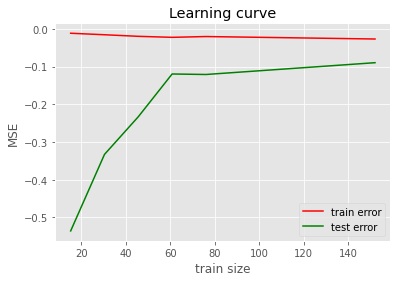

mse :  0.023024217109603753
mae :  0.08584637110829238
soc :  2828


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_5 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(235,235,235,235), (215,215,215,215)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_5, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
# results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

# _,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

# plt.title("Learning curve")
# plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
# plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
# plt.legend()
# plt.xlabel('train size')
# plt.ylabel('MSE')
# plt.show()

# mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

# std = np.std(mse)
# mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 4)

# arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
# print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


In [90]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_6 = {
 'activation': ['relu'], 
 'hidden_layer_sizes': [(90,90,90,90)], 
 'learning_rate_init': [0.01]
}
maes,socs,params=test(params_6,cv,5)
print(np.mean(maes))
maes,socs,params

0.08814831998478326


([0.088901078096281,
  0.08693130894502729,
  0.0905178430546592,
  0.08480514457707364,
  0.08958622525087515],
 [49593, 49593, 49593, 49593, 49593],
 [('relu', (90, 90, 90, 90)),
  ('relu', (90, 90, 90, 90)),
  ('relu', (90, 90, 90, 90)),
  ('relu', (90, 90, 90, 90)),
  ('relu', (90, 90, 90, 90))])

In [79]:
np.mean([0.09983318655463407,
  0.09900170459220828,
  0.10709119838909957,
  0.10837697174197461,
  0.11018576714608055])

0.1048977656847994

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (236, 236, 236, 236), 'learning_rate_init': 0.003593813663804626}


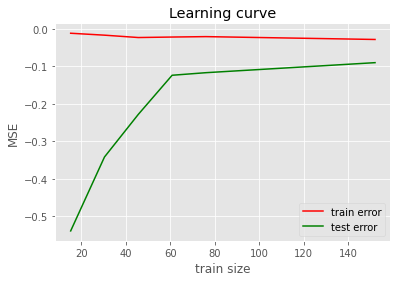

mse :  0.020468522613708216
mae :  0.08123698029122395
soc :  2840


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_7 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(236,236,236,236), (238,238,238,238), (239,239,239,239)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_7, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
# results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

# _,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

# plt.title("Learning curve")
# plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
# plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
# plt.legend()
# plt.xlabel('train size')
# plt.ylabel('MSE')
# plt.show()

# mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

# std = np.std(mse)
# mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 4)

# arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
# print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate_init': 0.01}


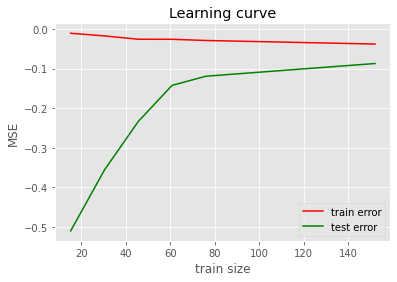

mse :  0.01925389875480499
mae :  0.08578292088793057
soc :  908


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(100,100,100), (75,75,75,75)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
# results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

# _,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

# plt.title("Learning curve")
# plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
# plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
# plt.legend()
# plt.xlabel('train size')
# plt.ylabel('MSE')
# plt.show()

# mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

# std = np.std(mse)
# mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 4)

# arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
# print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (75, 75, 75), 'learning_rate_init': 0.01}


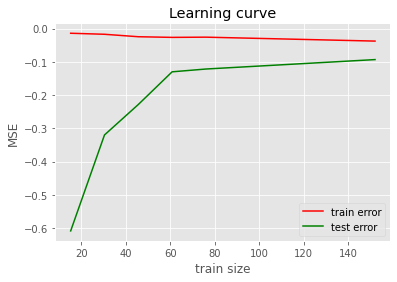

mse :  0.022197816316070196
mae :  0.08839466618411465
soc :  683


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(75,75,75), (100,100)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
# results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

# _,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

# plt.title("Learning curve")
# plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
# plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
# plt.legend()
# plt.xlabel('train size')
# plt.ylabel('MSE')
# plt.show()

# mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

# std = np.std(mse)
# mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 4)

# arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
# print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (70, 70, 70), 'learning_rate_init': 0.01}


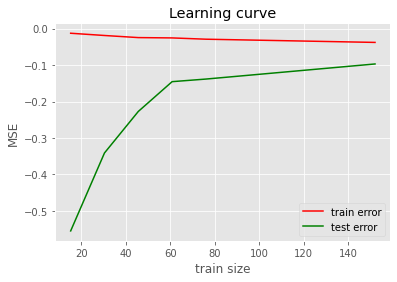

mse :  0.02547135112130905
mae :  0.08933839573024502
soc :  638


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(70,70,70), (50,50,50,50)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
# results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

# _,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

# plt.title("Learning curve")
# plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
# plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
# plt.legend()
# plt.xlabel('train size')
# plt.ylabel('MSE')
# plt.show()

# mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

# std = np.std(mse)
# mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 4)

# arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
# print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (72, 72, 72), 'learning_rate_init': 0.01}


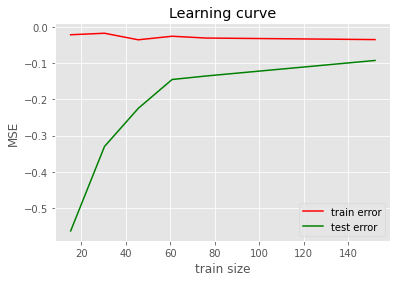

mse :  0.020772924963515894
mae :  0.08645720340546385
soc :  656


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(72,72,72), (74,74,74)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
# results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

# _,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

# plt.title("Learning curve")
# plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
# plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
# plt.legend()
# plt.xlabel('train size')
# plt.ylabel('MSE')
# plt.show()

# mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

# std = np.std(mse)
# mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 4)

# arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
# print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (71, 71, 71), 'learning_rate_init': 0.01}


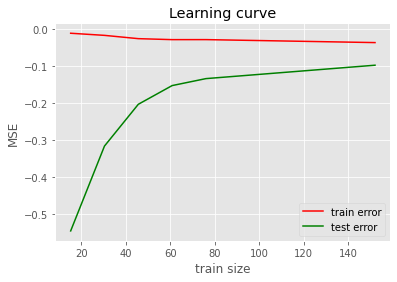

mse :  0.018790224339807093
mae :  0.08711166615528985
soc :  647


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(71,71,71)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
# results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 4)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50, 50), 'learning_rate_init': 0.01}


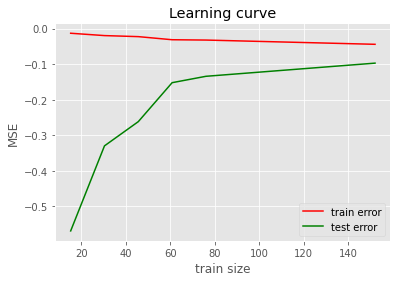

mse :  0.02165442328554145
mae :  0.09149339338467251
soc :  608


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(60,60,60), (50,50,50,50)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 4)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (65, 65, 65), 'learning_rate_init': 0.003593813663804626}


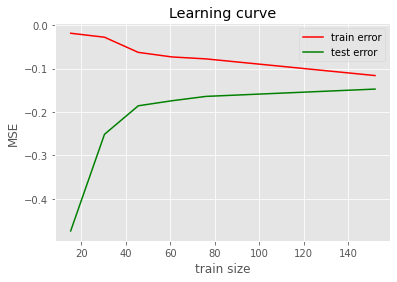

mse :  0.05369354506341841
mae :  0.14727679252030282
soc :  593


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(65,65,65), (67,67,67)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 4)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (68, 68, 68), 'learning_rate_init': 0.005994842503189409}


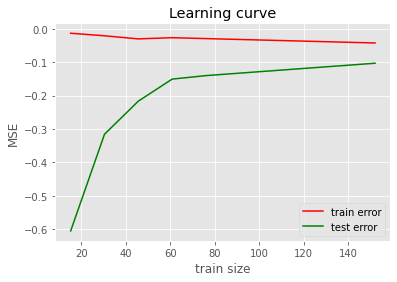

mse :  0.031161343417593586
mae :  0.09639759906836584
soc :  620


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(68,68,68), (69,69,69)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 4)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.01}


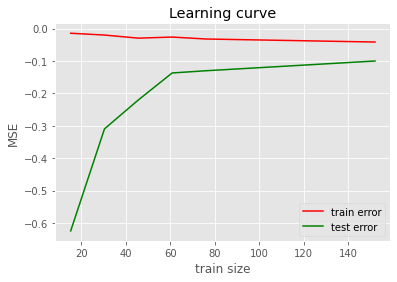

mse :  0.0296990666234249
mae :  0.09959353417037434
soc :  608


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(100,100)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 4)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

X = SelectKBest(f_regression, k=3).fit_transform(X_orig, y)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (71, 71, 71), 'learning_rate_init': 0.003593813663804626}


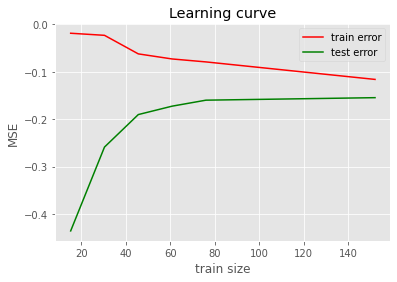

mse :  0.05404407135954821
mae :  0.1437292013392325
soc :  645


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['relu'], 
 'hidden_layer_sizes': [(71,71,71)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 3)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)



In [ ]:
arr_mae_min = [0.08123698029122395]
arr_soc_min = [2840]
arr_mae_min_soc = [0.08711166615528985]
arr_soc_min_soc = [647]

In [ ]:
arr_mae_not_allowed = [ x for x in arr_mae if x >= arr_mae_min[0]*1.1 ]
arr_mae_not_allowed

[0.09149339338467251,
 0.1437292013392325,
 0.14727679252030282,
 0.09959353417037434,
 0.09639759906836584]

In [ ]:
arr_soc, arr_mae

([1208,
  2408,
  3008,
  2708,
  2828,
  2852,
  2840,
  908,
  683,
  638,
  656,
  647,
  608,
  645,
  593,
  608,
  620],
 [0.08351253048286908,
  0.08800320732513323,
  0.08399009856390433,
  0.08536716631440969,
  0.08584637110829238,
  0.08793287147867831,
  0.08123698029122395,
  0.08578292088793057,
  0.08839466618411465,
  0.08933839573024502,
  0.08645720340546385,
  0.08711166615528985,
  0.09149339338467251,
  0.1437292013392325,
  0.14727679252030282,
  0.09959353417037434,
  0.09639759906836584])

In [ ]:
arr_mae_not_allowed_soc = [608,645,593,608,620]

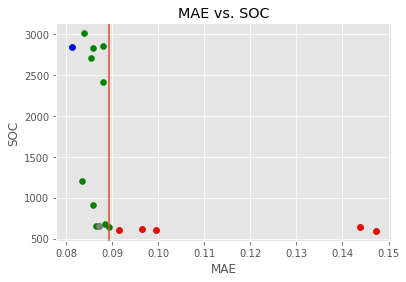

In [ ]:
plt.title("MAE vs. SOC")

plt.scatter(arr_mae, arr_soc, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.scatter(arr_mae_min_soc, arr_soc_min_soc, c='grey')
plt.axvline(x=arr_mae_min[0]*1.1)
plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

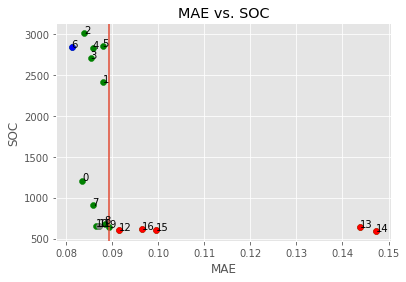

In [ ]:
plt.title("MAE vs. SOC")

plt.scatter(arr_mae, arr_soc, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.scatter(arr_mae_min_soc, arr_soc_min_soc, c='grey')
plt.axvline(x=arr_mae_min[0]*1.1)

for i, txt in enumerate(arr_mae):
    plt.annotate(i, (arr_mae[i], arr_soc[i]))

plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

In [ ]:
data = { 'MAE': arr_mae, 'SOC': arr_soc, 'Hidden Layer Size ': arr_hls }
df = pd.DataFrame(data)
df

,MAE,SOC,Hidden Layer Size
0,0.083513,1208,"(100, 100, 100, 100)"
1,0.088003,2408,"(200, 200, 200, 200)"
2,0.083990,3008,"(250, 250, 250, 250)"
3,0.085367,2708,"(225, 225, 225, 225)"
4,0.085846,2828,"(235, 235, 235, 235)"
5,0.087933,2852,"(237, 237, 237, 237)"
6,0.081237,2840,"(236, 236, 236, 236)"
7,0.085783,908,"(100, 100, 100)"
8,0.088395,683,"(75, 75, 75)"
9,0.089338,638,"(70, 70, 70)"
